**Group Project Proposal: Pulsar Star Classification**

**Introduction**

   Pulsars or Pulse Stars are highly magnetized neutron stars that radiate radio-wave emissions of two opposing narrow beams of light that are spinning, which we perceive on earth as blinking (Cofield, 2016). Each pulsar star emits a different emission pattern that varies with each of its rotations, therefore whenever there is a signal detection, or “candidate”, it is averaged over several rotations of the pulse star (Lyon, 2017). Each of these candidates are potential descriptions of a real pulse star. Radio frequency  interference and noise causes is responsible for most detections, the true pulse star signals are challenging to extract (Lyon, 2017).

   Our data set includes pulsar candidate data. Using this data, we will attempt to predict which of these candidates are legitimate pulsar stars and which are not. Our question is thus: __Can we differentiate legitimate pulsar stars from interference and noise using a classification model?__

Our Data set can be found here: https://archive.ics.uci.edu/ml/datasets/HTRU2

This data set includes 9 variables, which are as follows:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

  The integrated profile variables refer to a method used to describe the radiation pulsar stars emit. Individual pulses vary in shape, and their radiation is detected as individual photons which arrive infrequently (Lyne & Graham Smith, 2012). Thus, millions of pulse periods are required to construct the integrated profile (Lyne & Graham-Smith, 2012). The timing of the pulse’s arrival also varies across different radio frequencies. The delay between frequencies is known as dispersion (Krishnan, 2020). DM-SNR, or Dispersion Measure - Signal to noise ratio curves are created to adjust for the effect of these frequency delays (Krishnan, 2020). The variables 1-8 in this dataset thus describe the mean, skewness, standard deviation, and excess kurtosis of the integrated profile and DM-SNR curves. The Class variable refers to whether or not an observation is a pulsar star or not. If Class = 0, the observation is not a pulsar star, while if Class = 1, the observation is a pulsar star.



In [1]:
## install packages
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("tidymodels")


In [2]:
## load packages
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
## LOADING DATA ##

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
#Create temporary file to store zip file and download zip file
temp <- tempfile()
download.file(url, temp)

#read dataset (HTRU_2.csv) from zip file (temp) + give each column appropriate name
pulsar_data <- read_csv(unz(temp, "HTRU_2.csv"), col_names = c("Mean integrated profile", 
                                                         "Standard deviation integrated profile", 
                                                         "Excess kurtosis integrated profile", 
                                                         "Skewness integrated profile",
                                                         "Mean DM-SNR curve",
                                                         "Standard deviation DM-SNR curve",
                                                         "Excess kurtosis DM-SNR curve",
                                                         "Skewness DM-SNR curve",
                                                         "Class"))
#delete temporary file (because no longer needed)
unlink(temp)


## CLEANING & WRANGLING DATA INTO A TIDY FORMAT ##

# make the class column (that determines whether an observation is a pulsar or not) as a factor
pulsar_data <- pulsar_data %>% 
        mutate(Class = as_factor(Class))

#replace spaces in column names by dots
colnames(pulsar_data) = make.names(colnames(pulsar_data))

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean integrated profile, Standard deviation integrated profile, Exc...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
## EXPLORATORY DATA ANALYSIS ##

set.seed(1)
# splitting data into training and testing data

pulsar_split <- initial_split(pulsar_data, prop = .75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

## summarize training data: number of observations in each class type
pulsar_train_summary <- pulsar_train %>% 
  group_by(Class) %>% 
  summarize( n = n())

pulsar_train_summary

Class,n
<fct>,<int>
0,12200
1,1223


The table above shows that there are approximately 10x as many observations that are not pulsar stars as there are pulsar stars.

In [5]:
# means of the predictor variables
pulsar_predictor_means <- pulsar_train %>% 
  select(-Class) %>% 
  summarize(across(everything(), mean))

pulsar_predictor_means

Here, we explored the means of the different predictor variables. The means differ significantly, indicating the data will need to be centred and scaled for use in further analysis. 

In [5]:
# number of rows with missing data

pulsar_missing_data <- pulsar_train %>% 
    filter_at(vars(all_of(colnames(pulsar_train))), any_vars(is.na(.)))

number_of_rows_missing <- nrow(pulsar_missing_data)
number_of_rows_missing  # there are no missing data in this dataset

Mean.integrated.profile,Standard.deviation.integrated.profile,Excess.kurtosis.integrated.profile,Skewness.integrated.profile,Mean.DM.SNR.curve,Standard.deviation.DM.SNR.curve,Excess.kurtosis.DM.SNR.curve,Skewness.DM.SNR.curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.1363,46.56378,0.4749385,1.757917,12.47593,26.29282,8.305187,104.6209


[1] 0

In this part of the exploratory analysis, we examined the data to determine if there were observations which were missing data for any variables. However, there were not any observations missing data in our training data set.

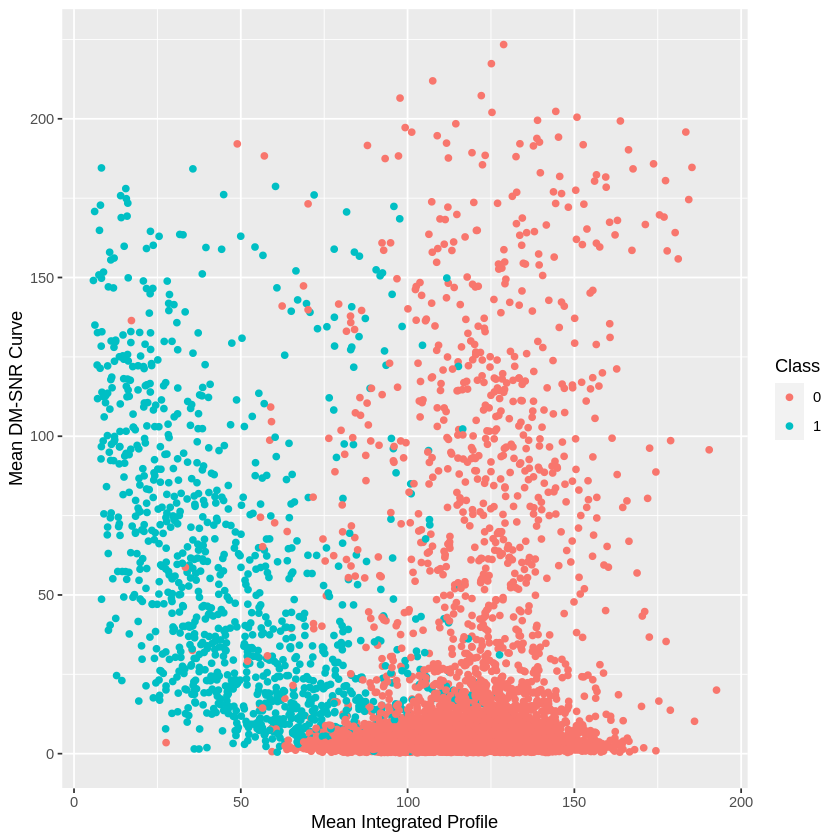

In [6]:
## EXPLORATORY DATA ANALYSIS: VISUALIZATIONS ##

## create a plot comparing the Mean Integrated Profile variable against the Mean DM-SNR Curve variable by Class
pulsar_plot1 <- pulsar_train %>% 
      ggplot(aes(x = Mean.integrated.profile, y = Mean.DM.SNR.curve, colour = Class))+
      geom_point()+
      labs( x = "Mean Integrated Profile" ,
            y =  "Mean DM-SNR Curve",
            colour = "Class" )

pulsar_plot1

**Methods**

Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

In order to perform our analysis, we will first split the data into training and testing data. We will use K- Nearest Neighbors Classification to create a model which will classify our testing data as a pulsar star or not.  We will first create the model, then use a 5-fold cross-validation technique to determine the K value that gives us the greatest predictive accuracy. Then we will re-train the model with the K-value obtained from the cross-validation process, then evaluate our model using the testing data. 

Describe at least one way that you will visualize the results

To visualize the results, we will create colored prediction map visualization . To do so, we will first create a dataset with 10,000 synthetic new observations (grid with 100 values for both predictors, 100*100 = 10,000), predict each label with our model, and create a scatter plot with a low `alpha` value. This will produce the effect of a colored plot, on top of which we will also plot the observations of the pulsar data. This will allow us to visualize how our model predicts data.

 -- explain why you are using x and y variables; reference graphs.

**Expected outcomes and significance**

What do you expect to find?

To classify each data sample as pulsar or not pulse stars, as well as the accuracy of the classifier.  

What impact could such findings have?

The findings could impact how accurate our current methods of predicting legitimate stars from data and impacting ways we could improve on data classification. 

What future questions could this lead to?

To what extent does classifying data accurately predict pulse stars from a group of candidates?
What are alternative ways we can predict pulse stars from the data, do those affect the accuracy? 
What can we improve in methods to differentiate noise and IFRs from the radio emissions from pulse stars?

**References**

Lyne, A., & Graham-Smith, F. (2012). 15 Integrated pulse profiles. In Pulsar Astronomy (Cambridge Astrophysics, pp. 207-229). Cambridge: Cambridge University Press. doi:10.1017/CBO9780511844584.016

Krishnan, Sowmya. (2020, September 27). Pulsar candidate classification. Medium. https://medium.com/swlh/pulsar-candidate-classification-a1805a369e17